# Real estate ROI calculator 

## Configurables
Change your url and location here

In [24]:
import datetime
import urllib.request
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy import Selector
import selenium
from selenium import webdriver
import chromedriver_binary
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 200)

import json
import re
import numpy as np
from crochet import setup

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

#Replace this url with the url of your search results
#url = 'https://www.immobilienscout24.de/Suche/de/berlin/berlin/wohnung-kaufen?enteredFrom=one_step_search'
# state/city
location = "berlin/berlin" 
location = "baden-wuerttemberg/pforzheim"
location = "niedersachsen/lueneburg-kreis"
location = "bayern/fuerth-kreis"
location = "hessen/bergstrasse-kreis"
location = "hessen/darmstadt-dieburg-kreis"
location = "baden-wuerttemberg"
location = "baden-wuerttemberg/mannheim"

# location = "sachsen-anhalt/magdeburg"
propertyType = 'wohnung'
# url_to_crawl = 'https://www.immobilienscout24.de/Suche/de/rheinland-pfalz/alzey-worms-kreis/wohnung-kaufen?enteredFrom=result_list'
# TODO build URLS that can also check 50km around
# https://www.immobilienscout24.de/Suche/radius/wohnung-kaufen?centerofsearchaddress=Heidelberg;;;1276001014;Baden-W%C3%BCrttemberg;&price=-150000.0&geocoordinates=49.40589;8.68357;50.0&enteredFrom=one_step_search

price_max = '150000'

url_to_crawl = 'https://www.immobilienscout24.de/Suche/de/' + location + '/'+propertyType+'-kaufen?price=-'+price_max+'&enteredFrom=result_list'

actualDate = datetime.date.today()
actualDate = actualDate.strftime('%Y-%m-%d')
city = location.split('/')[1] if len(location.split('/')) > 1 else location
file_name_csv = 'immobilienscout_result_' + city + '_' + actualDate + '.csv'
file_folder = 'data'
file_folder_raw = file_folder + '/raw/'
file_folder_interim = file_folder + '/interim/'
file_path_raw = file_folder_raw + file_name_csv
file_path_interim = file_folder_interim + file_name_csv

# Your variables to change
rent_price_index = 9
equity_percentage = 0.20
interest_rate = 0.01
mortgage_payment_rate = 0.02
equity_max = 30000
has_foreclosure = False

# Standard percentages
notary_percentage = 0.015
transfer_tax_percentage = 0.05
land_registry_tax_percentage = 0.005
additional_costs_rate_per_m2 = 0.9 

        
raw_columns = ['url', 'title', 'address', 'region', 'contact_person', 'telephone', 'mobile', 'fax', 'price_purchase', 'estimated_monthly_rate','rooms', 'living_area_m2', 'furnishing', 'flat_type', 'floor', 'floor_total', 'bedrooms', 'commission_buyer_rate', 'maintenance_cost', 'construction_year', 'object_state', 'heating_type', 'energy_efficiency_class', 'location', 'other_information']

2020-08-02 23:31:34 [matplotlib.pyplot] DEBUG: Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
import urllib.request
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy import Selector
import selenium
from selenium import webdriver
import chromedriver_binary
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 200)

import json
import re
import numpy as np
from crochet import setup

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

df_raw = pd.DataFrame(columns = raw_columns)

options = Options()
options.headless = True

crawler_name = 'scrapper_immobilienscout'

base_uri = 'immobilienscout24.de'
base_url = 'https://www.immobilienscout24.de'

driver = webdriver.Chrome()
# OLD configuration
#driver = webdriver.Chrome(options=options, executable_path="chromedriver.exe")

class Scrap_immobilienscout(scrapy.Spider):
    
    name = crawler_name
    
    def start_requests(self):
        first_page = urllib.request.urlopen(url_to_crawl)
        max_pages = first_page.read()
        max_pages = max_pages.decode("utf8")
        first_page.close()

        max_pages_selector = Selector(text = max_pages)
        max_pages = max_pages_selector.xpath('//select[@aria-label="Seitenauswahl"]/option[last()]/@value').extract_first()
        max_pages = int(max_pages) if max_pages is not None else 1
        
        base_url = url_to_crawl.replace('enteredFrom=one_step_search', '')

        for page_number in range(max_pages):
            url = base_url + '&pagenumber=' + str(page_number + 1)
            yield scrapy.Request(url, callback = self.parse_properties_list)
    
    def parse_properties_list(self, response):
        property_urls = response.xpath('//a[contains(@class, "result-list-entry__brand-title-container")]/@href').extract()
        for url in property_urls:
            if base_uri not in url:
                url = base_url + url + '#/'
                driver.get(url)
                src = driver.page_source
                self.scrap_property(src, url)
    
    def scrap_property(self, src, url):
        sel = Selector(text = src)
        title = sel.css('h1#expose-title ::text').extract_first()
        address = sel.xpath('//div[@class="address-block"]//span[@class="block font-nowrap print-hide"]//text()').extract_first()
        region = sel.css('span.zip-region-and-country::text').extract_first()
        contact_person = sel.xpath('//div[@data-qa="contactName"]//text()').extract_first()
        phone = sel.xpath('//script//text()').extract_first()
        phone = phone if phone is not None else ''
        telefon = re.findall('"phoneNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        mobil = re.findall('"cellPhoneNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        fax = re.findall('"faxNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        price = sel.xpath('//*[@id="is24-content"]/div[2]/div[1]/div[2]/div[1]/div[1]/div/div[1]/text()').extract_first()
        price = price if price else sel.xpath('//*[@id="is24-content"]/div[3]/div[1]/div[2]/div[1]/div[1]/div/div[1]/text()').extract_first()
        # TODO estimated_monthly_rate gets loaded dynamically we need some wait until its finishing with loading 
        # estimated_monthly_rate = sel.xpath('//span[contains(@class, "monthly-rate-result") and contains(@class, "monthly-rate-value")]//text()').extract_first()
        # estimated_monthly_rate = sel.xpath('//*[@id="is24-content"]/div[2]/div[1]/div[2]/div[1]/div[2]/div/div[3]/div[4]/span[3]/text()').extract_first()
        # estimated_monthly_rate = sel.xpath('//*[@id="is24-content"]/div[2]/div[1]/div[2]/div[1]/div[2]/div/div[2]/text()').extract_first()
        estimated_monthly_rate = None
        rooms_count = sel.xpath('//dd[contains(@class,"is24qa-zimmer")]/text()').extract_first()
        living_area = sel.xpath('//dd[contains(@class, "is24qa-wohnflaeche-ca")]/text()').extract_first()
        furnishing = sel.xpath('//div[contains(@class, "criteriagroup") and contains(@class, "boolean-listing")]//span[contains(@class, "palm-hide")]/text()').extract()
        flat_type = sel.xpath('//dd[contains(@class, "is24qa-typ")]/text()').extract_first()
        # TODO parse floor
        floor = sel.xpath('//dd[contains(@class, "is24qa-etage")]//text()').extract_first()
        floor = floor if floor is not None else ''
        floor = re.findall('[0-9]+', floor)
        total_floors = int(floor[1]) if len(floor) > 1 else 0
        floor = int(floor[0]) if len(floor) > 0 else 0
        bedroom = sel.xpath('//dd[contains(@class, "is24qa-schlafzimmer")]//text()').extract_first()
        allowance = sel.xpath('//dd[contains(@class, "is24qa-hausgeld")]//text()').extract_first()
        commission = sel.xpath('//dd[contains(@class, "is24qa-provision")]/text()').extract_first()
        construction_year = sel.xpath('//dd[contains(@class, "is24qa-baujahr")]//text()').extract_first()
        object_state = sel.xpath('//dd[contains(@class, "is24qa-objektzustand")]//text()').extract_first()
        heatingy_type = sel.xpath('//dd[contains(@class, "is24qa-heizungsart")]//text()').extract_first()
        energy_efficiency_class = sel.xpath('//dd[contains(@class, "is24qa-energieeffizienzklasse")]//text()').extract_first()
        location = sel.xpath('//pre[contains(@class, "is24qa-lage")]/text()').extract_first()
        other_information = sel.xpath('//*[@id="is24-content"]/div[2]/div[3]/pre/text()').extract_first()

        lst_row = [url, title, address, region, contact_person, telefon, mobil, fax, price, estimated_monthly_rate, rooms_count, living_area, furnishing, flat_type, floor, total_floors, bedroom, commission, allowance, construction_year, object_state, heatingy_type, energy_efficiency_class, location, other_information]
        df_raw.loc[len(df_raw)] = lst_row
        df_raw.to_csv(file_path_raw, index=False)

# DEBUG 
# process = CrawlerProcess()
# process.crawl(Scrap_immobilienscout)
# process.start(),
# DEBUG
setup()
def spider_process(spider):
    process = CrawlerProcess()
    process.crawl(spider)  

spider_process(Scrap_immobilienscout)

2020-08-02 23:27:02 [scrapy.utils.log] INFO: Scrapy 2.2.0 started (bot: scrapybot)
2020-08-02 23:27:02 [scrapy.utils.log] INFO: Versions: lxml 4.5.2.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 20.3.0, Python 3.7.4 (default, Sep  7 2019, 18:27:02) - [Clang 10.0.1 (clang-1001.0.46.4)], pyOpenSSL 19.1.0 (OpenSSL 1.1.1g  21 Apr 2020), cryptography 2.9.2, Platform Darwin-18.7.0-x86_64-i386-64bit
2020-08-02 23:27:02 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2020-08-02 23:27:02 [scrapy.crawler] INFO: Overridden settings:
{}
2020-08-02 23:27:02 [scrapy.extensions.telnet] INFO: Telnet Password: 9232467f7d6eba8a
2020-08-02 23:27:02 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.logstats.LogStats']
2020-08-02 23:27:02 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scra

In [4]:
df_raw

€               1992                Gepflegt    
26             None              1968                     None   
27             None              1900                     None   
28             None              1968                     None   
29           195 €               1951                     None   
30           150 €               1965                Gepflegt    
31             None              1965                     None   
32             None              1912                     None   
33             None              1990                     None   
34             None              1964                Gepflegt    
35             None              1964                Gepflegt    
36           276 €               1968            Modernisiert    
37           108 €               1992   Vollständig renoviert    
38           105 €               1989                     None   
39           100 €               1960   Renovierungsbedürftig    

           heating_type energy_efficiency_class  \
0            Fernwärme                       D    
1       Zentralheizung                       C    
2            Fernwärme                     None   
3          Ofenheizung                     None   
4                  None                    None   
5                  None                      E    
6                  None                    None   
7                  None                      F    
8            Fernwärme                     None   
9       Zentralheizung                       C    
10      Zentralheizung                     None   
11      Zentralheizung                       E    
12                 None                      E    
13                 None                    None   
14      Zentralheizung                      A+    
15      Zentralheizung                       C    
16      Zentralheizung                       D    
17     Fußbodenheizung                     None   
18           Fernwärme                     None   
19                 None                    None   
20           Fernwärme                     None   
21      Zentralheizung                     None   
22                 None                    None   
23           Fernwärme                     None   
24           Fernwärme                     None   
25           Fernwärme                     None   
26                 None                      D    
27       Etagenheizung                     None   
28      Zentralheizung                     None   
29      Zentralheizung                       B    
30      Zentralheizung                     None   
31                 None                    None   
32                 None                    None   
33                 None                    None   
34      Zentralheizung                     None   
35      Zentralheizung                     None   
36      Zentralheizung                       F    
37      Zentralheizung                     None   
38      Zentralheizung                       C    
39   Nachtspeicheröfen                       E    

                                                                                                                                                                                                   location  \
0   Das Appartmenthaus liegt am Rande des gewachsenen Stadtteils Neckarau \nmit sehr guten Verkehrsanschlüssen.\n:\nBundesbahnstation Mannheim-Neckarau, gegenüber dem Appartmenthaus liegend,\nHalteste...   
1   Die Wohnung liegt im beliebten Stadtteil Neckarau unweit des Badesees Stollenwörthweiher und des Waldparks. Einkaufsmöglichkeiten und Tramhaltestellen sind gut zu Fuß zu erreichen. Die Tram 3 in R...   
2                                                                                    Perreystr. 24-26 68219 Mannheim\nVor Ort: Rheinauer See, Autobahnanbindung, Bussanbindung, Einkaufsmöglichkeiten, etc.   
3              MA-Rheinau\nVollkommende Infrastruktur mit allen Einkaufsmöglichkeiten (Penny, Lidl, Rossma

## Data Preparation 

In [5]:
# Read CSV again
file_path_raw_selected = ''
file_path_raw = file_path_raw_selected if file_path_raw_selected != '' else file_path_raw
df_raw = pd.read_csv(file_path_raw)

In [6]:
## Parser
def parse_expose_id(url):
    id = url.split('/')[-2]
    return id

def parse_address(address, region):
    address = address.strip() if address is not None else ''
    address += ' ' + region if region is not None else ''
    return address

def parse_contact_person(contact_person):
    return contact_person if contact_person is not None else ''

def parse_telefon(telefon):
    return telefon[0].replace(' ', '') if len(telefon) > 0 else None

def parse_mobile(mobile): 
    mobile = mobile[0] if len(mobile) > 0 else ''
    return mobile.replace(' ', '')

def parse_fax(fax):
    fax = fax[0] if len(fax) > 0 else ''
    return fax.replace(' ', '')

def parse_price(price):
    price = re.sub('[^0-9]\s*', '', str(price)) if price else 0
    return int(price) if price is not '' else 0

def parse_estimated_monthly_rate(estimated_monthly_rate):
    estimated_monthly_rate = re.sub('[^0-9]', '', str(estimated_monthly_rate)) if estimated_monthly_rate else 0
    return int(estimated_monthly_rate) if estimated_monthly_rate is not '' else 0

def parse_commision(commission):
    if commission is not None:
        try:
            commission = re.search('[0-9]+,?[0-9]*', commission).group() 
        except:
            commission = ''
    else:
        commission = ''

    commission = commission.replace(',', '.')
    return float(commission) if len(commission) > 0 else 0

def parse_rooms_count(rooms_count):
    return float(str(rooms_count).replace(" ","").replace(",",".") ) if rooms_count is not None else 0

def parse_living_area(living_area):
    living_area = re.sub('[^0-9\.]', '', str(living_area).replace(",",".")) if living_area is not None else 0
    return float(living_area) if living_area else 0

def parse_furnishing(furnishing):
    print(furnishing)
    furnishing = list(set(furnishing))
    furnishing = [t for t in furnishing if t != ' ']
    print(furnishing)
    return furnishing if len(furnishing) > 0 else ''

def parse_bedroom(bedroom):
    bedroom = re.sub('[^0-9]', '', str(bedroom)) if bedroom is not None else 0
    return int(bedroom) if bedroom else 0

def parse_allowance(allowance):
    allowance = re.sub('[^0-9]', '', str(allowance)) if allowance is not None else 0
    return int(allowance) if allowance else 0

def parse_energy_efficiency_class(energy_efficiency_class):
    return energy_efficiency_class if energy_efficiency_class is not None else ''

In [7]:
df_base = df_raw.copy()
# TODO clarify default values
# TODO fix parse issues (int, roundings, etc.)
# TODO fix address
# df_base['address'] = df_base.apply(lambda x: parse_address(x['address'], x['region']) if x.name in ['address'] else x)
df_base['id_expose'] = df_base['url'].apply(parse_expose_id)
df_base['contact_person'] = df_base['contact_person'].apply(parse_contact_person)
df_base['telephone'] = df_base['telephone'].apply(parse_telefon)
df_base['mobile'] = df_base['mobile'].apply(parse_mobile)
df_base['fax'] = df_base['fax'].apply(parse_fax)
df_base['price_purchase'] = df_base['price_purchase'].apply(parse_price)
df_base['commission_buyer_rate'] = df_base['commission_buyer_rate'].apply(parse_commision)
df_base['estimated_monthly_rate'] = df_base['estimated_monthly_rate'].apply(parse_estimated_monthly_rate)
df_base['rooms'] = df_base['rooms'].apply(parse_rooms_count)
df_base['living_area_m2'] = df_base['living_area_m2'].apply(parse_living_area)
# df_base['furnishing'] = df_base['furnishing'].apply(parse_furnishing) # seems to be unecessary
df_base['bedrooms'] = df_base['bedrooms'].apply(parse_bedroom)
df_base['maintenance_cost'] = df_base['maintenance_cost'].apply(parse_allowance)
df_base['energy_efficiency_class'] = df_base['energy_efficiency_class'].apply(parse_energy_efficiency_class)


In [8]:
df_base

.0            Modernisiert    
37               108             1992.0   Vollständig renoviert    
38               105             1989.0                      NaN   
39               100             1960.0   Renovierungsbedürftig    

           heating_type energy_efficiency_class  \
0            Fernwärme                       D    
1       Zentralheizung                       C    
2            Fernwärme                      NaN   
3          Ofenheizung                      NaN   
4                   NaN                     NaN   
5                   NaN                      E    
6                   NaN                     NaN   
7                   NaN                      F    
8            Fernwärme                      NaN   
9       Zentralheizung                       C    
10      Zentralheizung                      NaN   
11      Zentralheizung                       E    
12                  NaN                      E    
13                  NaN                     NaN   
14      Zentralheizung                      A+    
15      Zentralheizung                       C    
16      Zentralheizung                       D    
17     Fußbodenheizung                      NaN   
18           Fernwärme                      NaN   
19                  NaN                     NaN   
20           Fernwärme                      NaN   
21      Zentralheizung                      NaN   
22                  NaN                     NaN   
23           Fernwärme                      NaN   
24           Fernwärme                      NaN   
25           Fernwärme                      NaN   
26                  NaN                      D    
27       Etagenheizung                      NaN   
28      Zentralheizung                      NaN   
29      Zentralheizung                       B    
30      Zentralheizung                      NaN   
31                  NaN                     NaN   
32                  NaN                     NaN   
33                  NaN                     NaN   
34      Zentralheizung                      NaN   
35      Zentralheizung                      NaN   
36      Zentralheizung                       F    
37      Zentralheizung                      NaN   
38      Zentralheizung                       C    
39   Nachtspeicheröfen                       E    

                                                                                                                                                                                                   location  \
0   Das Appartmenthaus liegt am Rande des gewachsenen Stadtteils Neckarau \nmit sehr guten Verkehrsanschlüssen.\n:\nBundesbahnstation Mannheim-Neckarau, gegenüber dem Appartmenthaus liegend,\nHalteste...   
1   Die Wohnung liegt im beliebten Stadtteil Neckarau unweit des Badesees Stollenwörthweiher und des Waldparks. Einkaufsmöglichkeiten und Tramhaltestellen sind gut zu Fuß zu erreichen. Die Tram 3 in R...   
2                                                                                    Perreystr. 24-26 68219 Mannheim\nVor Ort: Rheinauer See, Autobahnanbindung, Bussanbindung, Einkaufsmöglichkeiten, etc.   
3              MA-Rheinau\nVollkommende Infrastruktur mit allen Einkaufsmöglichkeiten (Penny, Lidl, Rossmann, REWE) für den täglichen Bedarf, sowie öffentliche Verkehrsmittel wenigen Gehminuten entfernt.   
4                                                                                                                                                                                                       NaN   
5   Schwetzingen - Nordstadt - zentral gelegen. \n\nDie Bahnlinie führt in 150m am Feldrand entlang vorbei. \n\nDas schöne Schwetzinger Schloss mit seinem traumhaften Schlossgarten erreichen Sie in we...   
6   Hockenheim ist eine Stadt im nordwestlichen von Baden-Württemberg etwa 20 km südlich von Mannheim.Sie ist die sechst größte Stadt im Rhein-Neckar-Kreis.Seid dem 1 Januar 2001 ist Hockenheim eine G...   
7   Heidelberg-S

## Exploration

In [9]:
# dataframe dimensions
df_base.shape

(40, 26)

In [10]:
# column datatypes
df_base.dtypes

url                         object
title                       object
address                     object
region                      object
contact_person              object
telephone                   object
mobile                      object
fax                         object
price_purchase               int64
estimated_monthly_rate       int64
rooms                      float64
living_area_m2             float64
furnishing                  object
flat_type                   object
floor                        int64
floor_total                  int64
bedrooms                     int64
commission_buyer_rate      float64
maintenance_cost             int64
construction_year          float64
object_state                object
heating_type                object
energy_efficiency_class     object
location                    object
other_information           object
id_expose                   object
dtype: object

In [11]:
df_base.select_dtypes(include=['object']).isnull().sum()

url                         0
title                       0
address                    31
region                      0
contact_person              0
telephone                   0
mobile                      0
fax                         0
furnishing                  0
flat_type                  14
object_state               19
heating_type               12
energy_efficiency_class    25
location                    9
other_information           7
id_expose                   0
dtype: int64

In [12]:
df_base.head(10)
#df_base['url'][4]
#df[0:5]
#df.tail()

url  \
0  https://www.immobilienscout24.de/expose/116942625#/   
1  https://www.immobilienscout24.de/expose/115948723#/   
2  https://www.immobilienscout24.de/expose/115642755#/   
3  https://www.immobilienscout24.de/expose/109593788#/   
4  https://www.immobilienscout24.de/expose/119919400#/   
5  https://www.immobilienscout24.de/expose/118069570#/   
6  https://www.immobilienscout24.de/expose/110876731#/   
7  https://www.immobilienscout24.de/expose/121121726#/   
8  https://www.immobilienscout24.de/expose/118108113#/   
9  https://www.immobilienscout24.de/expose/117054847#/   

                                                                                                  title  \
0  Top -Lage - 1 Zim.-App. als Kapitalanlage oder noch Selbstbezug möglich - direkte OEG, Bahnhof, etc.   
1                                                      Helle und gepflegte 1-Zimmer Dachgeschosswohnung   
2                                                Appartement in der Nähe vom Rheinauer See in Mannheim!   
3                              **KAPITALANLEGER AUFGEPASST! Gemütliche 2 ZKB + 2 Balkone / MA-Rheinau**   
4                                                                          Gemütliche 2-Zimmer-Wohnung!   
5                                  ***KAPITALANLÄGER AUFGEPASST - ATTRAKTIVE WOHNUNG IN SCHWETZINGEN***   
6                                              Schöne 2 Zimmer Wohnung plus 2 Stellplätze in Hockenheim   
7                             Vermietet 1 Zimmer- Wohnung in zentraler Lage - Ideal für Kapitalanleger!   
8        Zentrumsnahe 1 Zimmer Etagenwohnung, 42 qm mit traumhaften Ausblick in HD-Boxberg zu verkaufen   
9                                                        Vermietete 1-Zimmerwohnung mit Garage & Balkon   

                  address                                  region  \
0   Neckarauer Straße 23,                68199 Mannheim, Neckarau   
1                     NaN               68199 Mannheim, Lindenhof   
2        Perreystr 24-26,                 68219 Mannheim, Rheinau   
3                     NaN                 68219 Mannheim, Rheinau   
4                     NaN   74927 Eschelbronn, Rhein-Neckar-Kreis   
5                     NaN  68723 Schwetzingen, Rhein-Neckar-Kreis   
6                     NaN    68766 Hockenheim, Rhein-Neckar-Kreis   
7                     NaN              69126 Heidelberg, Südstadt   
8         Boxbergring 12,               69126 Heidelberg, Boxberg   
9                     NaN              69126 Heidelberg, Rohrbach   

                          contact_person telephone mobile fax  price_purchase  \
0          Frau Melanie Höll, Immobilien         [      [   [           88000   
1                       Frau W. Bochenek         [      [   [          129500   
2        Frau Dipl.-Ing. Edina Osmanovic         [      [   [           99000   
3                          Frau Tülay Öc         [      [   [          115000   
4  Frau Dipl.-Wi.Jur. Meric Yildiz-Islak         [      [   [          115000   
5                    Frau Susanne Nolden         [      [   [          148000   
6            Frau Bähr  BAEHR-Immobilien         [      [   [          141000   
7                    Immobilienabteilung         [      [   [          115000   
8                     Frau Tina Feindler         [      [   [          110000   
9                   Herr Daniele De Luca         [      [   [          149000   

   estimated_monthly_rate  rooms  living_area_m2  \
0                       0    1.0           20.77   
1                       0    1.0           35.00   
2                       0    1.0           33.14   
3                       0    2.0           49.00   
4                       0    2.0           60.00   
5                       0    1.0           51.33   
6                       0    2.0           60.00   
7                       0    1.0           23.00   
8                       0    1.5           42.00   
9                       0    1.0           39.00   

         

In [13]:
# TODO transform into numerical values for historgrams
# df_base.hist(xrot=-45, figsize=(14,14))

In [14]:
df_base.describe()

price_purchase  estimated_monthly_rate      rooms  living_area_m2  \
count       40.000000                    40.0  40.000000        40.00000   
mean    114882.500000                     0.0   1.662500        64.85525   
std      36115.746175                     0.0   0.865192       118.75030   
min          0.000000                     0.0   1.000000        20.00000   
25%      97750.000000                     0.0   1.000000        32.50000   
50%     122500.000000                     0.0   1.250000        43.00000   
75%     143500.000000                     0.0   2.000000        54.50000   
max     150000.000000                     0.0   4.000000       778.45000   

           floor  floor_total   bedrooms  commission_buyer_rate  \
count  40.000000    40.000000  40.000000              40.000000   
mean    1.825000     2.100000   4.500000               4.126250   
std     2.194252     2.619454   6.385079               2.016032   
min     0.000000     0.000000   0.000000               0.000000   
25%     0.000000     0.000000   0.000000               3.480000   
50%     1.000000     0.000000   0.000000               4.700000   
75%     3.000000     4.000000  10.000000               5.825000   
max    10.000000     8.000000  30.000000               7.140000   

       maintenance_cost  construction_year  
count         40.000000          38.000000  
mean         324.225000        1974.078947  
std         1568.455512          23.976770  
min            0.000000        1900.000000  
25%            0.000000        1964.250000  
50%           50.000000        1979.500000  
75%          157.750000        1992.750000  
max         9982.000000        1998.000000

In [15]:
df_base.describe(include='object')

url  \
count                                                    40   
unique                                                   40   
top     https://www.immobilienscout24.de/expose/118780535#/   
freq                                                      1   

                                                                                  title  \
count                                                                                40   
unique                                                                               40   
top     1-Zimmer Appartement mit Balkon und TG-Stellplatz in ruhiger Lage in Heddesheim   
freq                                                                                  1   

                 address                                region  \
count                  9                                    40   
unique                 9                                    23   
top      Boxbergring 12,  68766 Hockenheim, Rhein-Neckar-Kreis   
freq                   1                                     4   

                                    contact_person telephone mobile fax  \
count                                           40        40     40  40   
unique                                          36         1      1   1   
top      Ihr Partner für Immobilienversteigerungen         [      [   [   
freq                                             3        40     40  40   

       furnishing        flat_type object_state      heating_type  \
count          40               26           21                28   
unique         21                4            5                 6   
top            []   Etagenwohnung     Gepflegt    Zentralheizung    
freq            5               17           13                16   

       energy_efficiency_class  \
count                       15   
unique                       6   
top                         E    
freq                         4   

                                                                                                                                                                                                       location  \
count                                                                                                                                                                                                        31   
unique                                                                                                                                                                                                       29   
top     Rheinau liegt im Südosten Mannheims westlich der Autobahn A 6. \n\nAngrenzende Stadtbezirke sind Neckarau, Seckenheim und Friedrichsfeld. \nIm Süden befindet sich Brühl-Rohrhof, das zum Rhein-Neck...   
freq                                                                                                                                                                                                          2   

                                                                                                                                                                                              other_information  \
count                                                                                                                                                                                                        33   
unique                                                                                                                                                                                                       30   
top     Die AZ Agentur für Zwangsversteigerungsinformationen GmbH ist der führende Herausgeber von Informationen zu dem Thema Zwangsversteigerungen von Immobilien. Bei uns finden Sie alle Versteigerungste...   
freq                                                                                                                                                            

3:28:35 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
2020-08-02 23:28:35 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
2020-08-02 23:28:35 [matplotlib.font_manager] DEBUG: findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Medium.otf) normal normal 500 normal>) = 10.145
2020-08-02 23:28:35 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05
2020-08-02 23:28:35 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 10.05
2020-08-02 23:28:35 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-08-02 23:28:35 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal nor

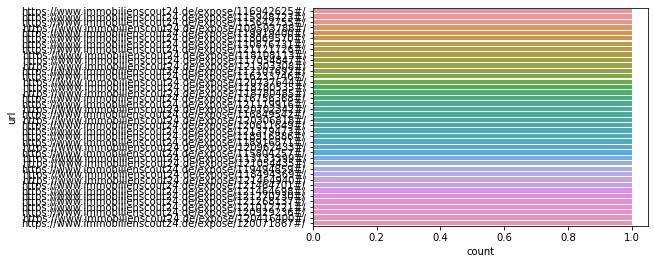

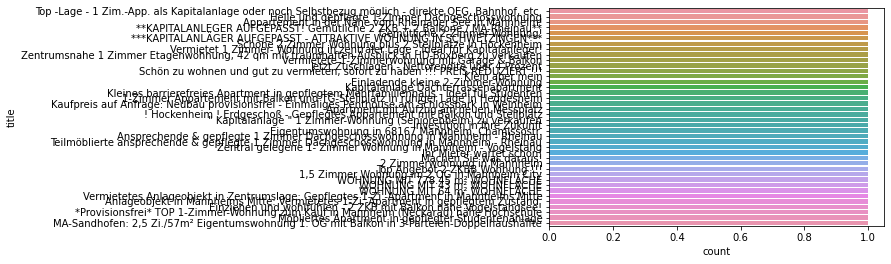

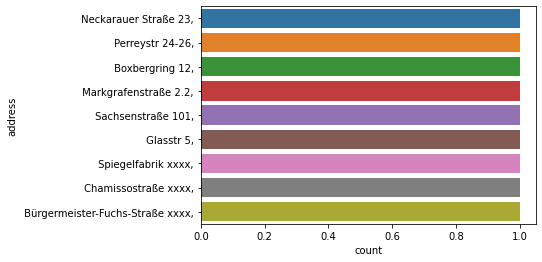

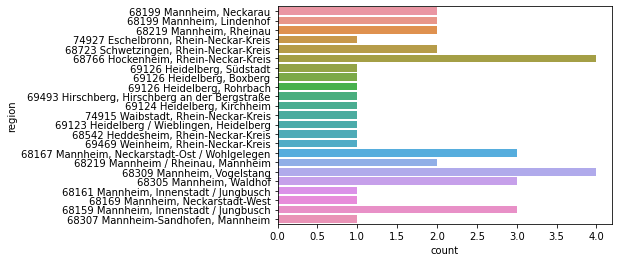

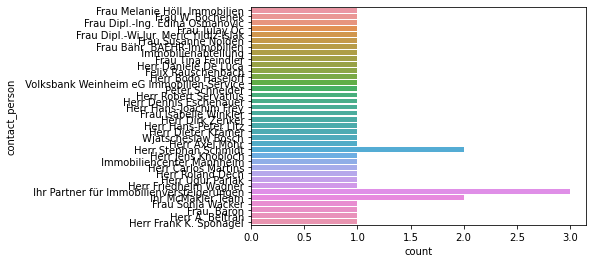

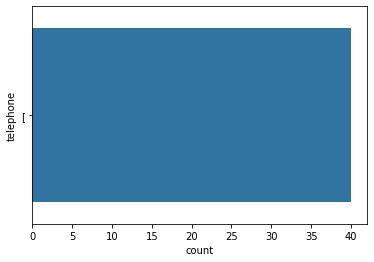

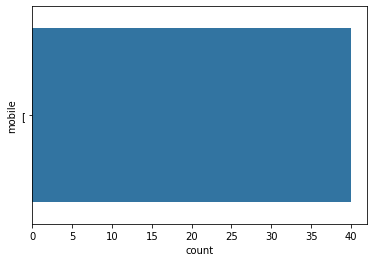

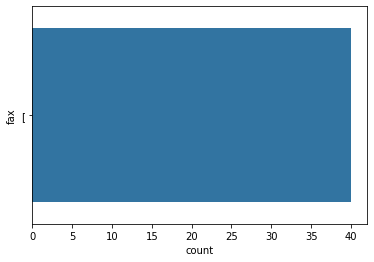

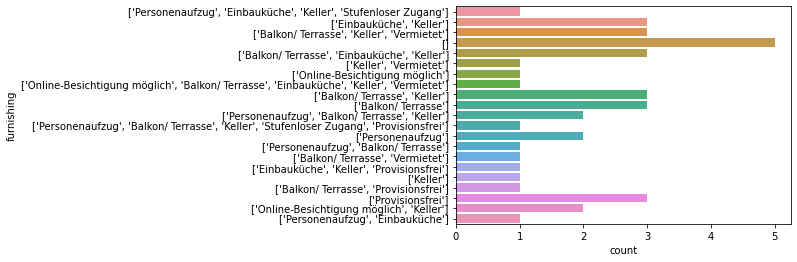

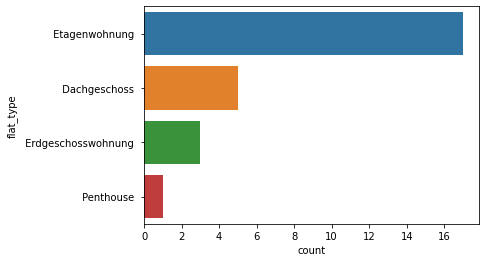

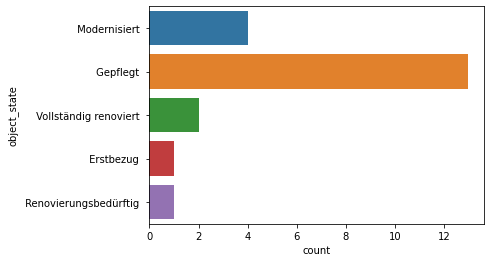

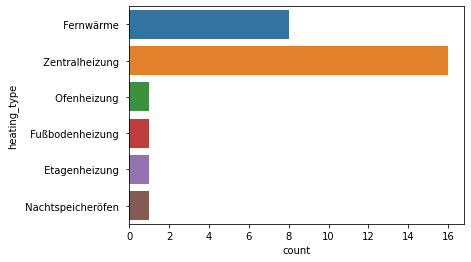

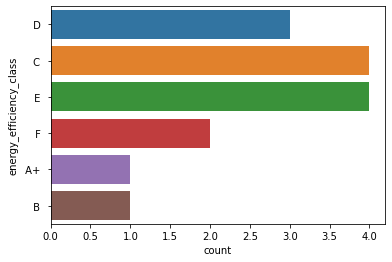

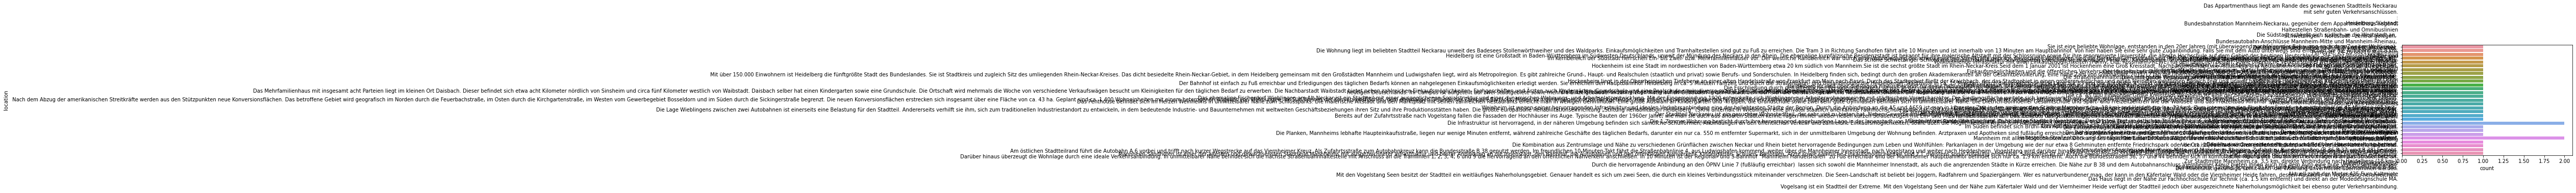

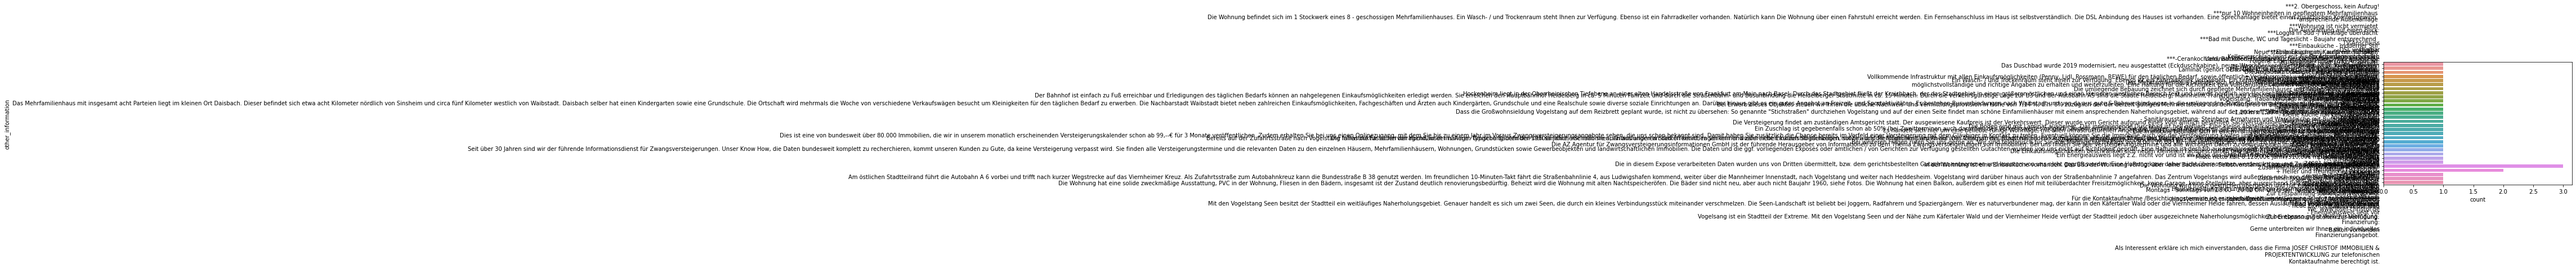

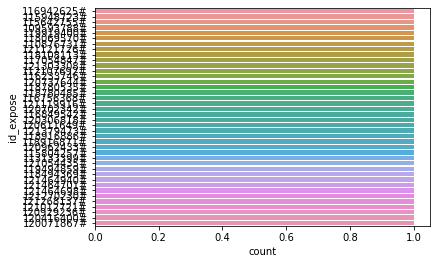

In [16]:
# TODO fix usage of list
# TODO data needs to be fixed
for features in df_base.dtypes[df_base.dtypes == 'object'].index:
    sns.countplot(y=features, data=df_base)
    plt.show()

## Data argmentation
Goal is to calculate the yearly ROI

In [25]:
df_finance = df_base[['url','price_purchase', 'living_area_m2', 'commission_buyer_rate']]
df_finance['is_foreclosure'] = df_base['other_information'].str.contains('Zwangsversteigerung', na = False)
df_finance['price_per_m2'] = df_finance['price_purchase'] / df_finance['living_area_m2']
df_finance['notary_costs'] = notary_percentage * df_finance['price_purchase']

df_finance['land_registry_tax'] = land_registry_tax_percentage * df_finance['price_purchase']
df_finance['real_estate_transfer_tax'] = transfer_tax_percentage * df_finance['price_purchase']
df_finance['commission'] = df_finance['price_purchase'] * df_finance['commission_buyer_rate'] * 0.01 # TODO fix while parsing from scraper already
df_finance['total_buying_price'] = df_finance['price_purchase'] + df_finance['notary_costs'] + df_finance['land_registry_tax'] + df_finance['real_estate_transfer_tax'] + df_finance['commission']
df_finance['equity'] = equity_percentage * df_finance['total_buying_price']
df_finance['debt'] = df_finance['total_buying_price'] - df_finance['equity']
df_finance['interest_rate_monthly'] = interest_rate * df_finance['debt'] / 12
df_finance['mortgage_payment_yearly'] = mortgage_payment_rate * df_finance['debt']
df_finance['mortgage_payment_monthly'] = df_finance['mortgage_payment_yearly'] / 12
df_finance['monthly_rent'] = rent_price_index * df_finance['living_area_m2']
df_finance['additional_costs'] = additional_costs_rate_per_m2 * df_finance['living_area_m2']
df_finance['cashflow'] = df_finance['monthly_rent'] - df_finance['interest_rate_monthly'] - df_finance['mortgage_payment_monthly'] - df_finance['additional_costs']
df_finance['ROI'] = (df_finance['cashflow'] * 12) / df_finance['equity'] 





## Data Evaluation

In [26]:
# TODO Put every step into CSV
# Read CSV again
# file_path_interim_selected = ''
# file_path_interim = file_path_interim_selected if file_path_interim_selected != '' else file_path_interim
# df_finance = pd.read_csv(file_path_raw)

In [27]:
df_interim = df_finance.copy()
df_interim = df_interim.sort_values(by=['ROI'], ascending=False)
df_interim.to_csv(file_path_interim, index=False)

In [28]:
if has_foreclosure:
    # df_finance = df_finance[df_finance['is_foreclosure']] 
    None
else:
    df_finance = df_finance[df_finance['is_foreclosure'] == False] 


In [29]:
df_finance.sort_values(by=['ROI'], ascending=False)

url  price_purchase  \
10  https://www.immobilienscout24.de/expose/121303308#/               0   
17  https://www.immobilienscout24.de/expose/121119916#/               0   
4   https://www.immobilienscout24.de/expose/119919400#/          115000   
13  https://www.immobilienscout24.de/expose/120737644#/          107000   
3   https://www.immobilienscout24.de/expose/109593788#/          115000   
6   https://www.immobilienscout24.de/expose/110876731#/          141000   
26  https://www.immobilienscout24.de/expose/115804257#/          149000   
39  https://www.immobilienscout24.de/expose/120071867#/          140000   
29  https://www.immobilienscout24.de/expose/119494859#/          145000   
27  https://www.immobilienscout24.de/expose/113133399#/          139000   
20  https://www.immobilienscout24.de/expose/120306818#/           92800   
8   https://www.immobilienscout24.de/expose/118108113#/          110000   
36  https://www.immobilienscout24.de/expose/121012721#/          125000   
16  https://www.immobilienscout24.de/expose/116756368#/           86000   
14  https://www.immobilienscout24.de/expose/118780535#/          149000   
23  https://www.immobilienscout24.de/expose/118916886#/           82000   
28  https://www.immobilienscout24.de/expose/121054435#/          135000   
5   https://www.immobilienscout24.de/expose/118069570#/          148000   
35  https://www.immobilienscout24.de/expose/121268137#/          150000   
2   https://www.immobilienscout24.de/expose/115642755#/           99000   
34  https://www.immobilienscout24.de/expose/121270230#/          150000   
19  https://www.immobilienscout24.de/expose/116849542#/          112000   
18  https://www.immobilienscout24.de/expose/120702342#/          120000   
24  https://www.immobilienscout24.de/expose/118916871#/           85000   
11  https://www.immobilienscout24.de/expose/112107692#/          148000   
25  https://www.immobilienscout24.de/expose/120962433#/           99000   
1   https://www.immobilienscout24.de/expose/115948723#/          129500   
9   https://www.immobilienscout24.de/expose/117054847#/          149000   
0   https://www.immobilienscout24.de/expose/116942625#/           88000   
30  https://www.immobilienscout24.de/expose/118494369#/          125000   
38  https://www.immobilienscout24.de/expose/120416400#/          143000   
12  https://www.immobilienscout24.de/expose/116233746#/          150000   
21  https://www.immobilienscout24.de/expose/120611649#/           94000   
7   https://www.immobilienscout24.de/expose/121121726#/          115000   
37  https://www.immobilienscout24.de/expose/120929236#/          115000   
15  https://www.immobilienscout24.de/expose/118780485#/          125000   

    living_area_m2  commission_buyer_rate  is_foreclosure  price_per_m2  \
10          114.00                   4.00           False      0.000000   
17          173.00                   0.00           False      0.000000   
4            60.00                   3.48           False   1916.666667   
13           50.00                   3.48           False   2140.000000   
3            49.00                   3.57           False   2346.938776   
6            60.00                   5.95           False   2350.000000   
26           62.00                   5.95           False   2403.225806   
39           57.00                   3.57           False   2456.140351   
29           60.00                   5.95           False   2416.666667   
27           56.00                   3.57           False   2482.142857   
20           36.00                   5.00           False   2577.777778   
8            42.00                   5.95           False   2619.047619   
36           46.50                   4.76           False   2688.172043   
16           31.00                   3.33           False   2774.193548   
14           54.00                   4.64           False   2759.259259   
23           30.00                   5.90           False   2733.333333   
2

In [30]:
df_finance[(df_finance['cashflow'] > 0) ].sort_values(by=['ROI'], ascending=False).head(20)

url  price_purchase  \
17  https://www.immobilienscout24.de/expose/121119916#/               0   
10  https://www.immobilienscout24.de/expose/121303308#/               0   
4   https://www.immobilienscout24.de/expose/119919400#/          115000   
13  https://www.immobilienscout24.de/expose/120737644#/          107000   
3   https://www.immobilienscout24.de/expose/109593788#/          115000   
6   https://www.immobilienscout24.de/expose/110876731#/          141000   
26  https://www.immobilienscout24.de/expose/115804257#/          149000   
39  https://www.immobilienscout24.de/expose/120071867#/          140000   
29  https://www.immobilienscout24.de/expose/119494859#/          145000   
27  https://www.immobilienscout24.de/expose/113133399#/          139000   
20  https://www.immobilienscout24.de/expose/120306818#/           92800   
8   https://www.immobilienscout24.de/expose/118108113#/          110000   
36  https://www.immobilienscout24.de/expose/121012721#/          125000   
16  https://www.immobilienscout24.de/expose/116756368#/           86000   
14  https://www.immobilienscout24.de/expose/118780535#/          149000   
23  https://www.immobilienscout24.de/expose/118916886#/           82000   
28  https://www.immobilienscout24.de/expose/121054435#/          135000   
5   https://www.immobilienscout24.de/expose/118069570#/          148000   
35  https://www.immobilienscout24.de/expose/121268137#/          150000   
2   https://www.immobilienscout24.de/expose/115642755#/           99000   

    living_area_m2  commission_buyer_rate  is_foreclosure  price_per_m2  \
17          173.00                   0.00           False      0.000000   
10          114.00                   4.00           False      0.000000   
4            60.00                   3.48           False   1916.666667   
13           50.00                   3.48           False   2140.000000   
3            49.00                   3.57           False   2346.938776   
6            60.00                   5.95           False   2350.000000   
26           62.00                   5.95           False   2403.225806   
39           57.00                   3.57           False   2456.140351   
29           60.00                   5.95           False   2416.666667   
27           56.00                   3.57           False   2482.142857   
20           36.00                   5.00           False   2577.777778   
8            42.00                   5.95           False   2619.047619   
36           46.50                   4.76           False   2688.172043   
16           31.00                   3.33           False   2774.193548   
14           54.00                   4.64           False   2759.259259   
23           30.00                   5.90           False   2733.333333   
28           48.00                   5.95           False   2812.500000   
5            51.33                   5.95           False   2883.304111   
35           51.00                   5.80           False   2941.176471   
2            33.14                   5.80           False   2987.326494   

    notary_costs  land_registry_tax  real_estate_transfer_tax  commission  \
17           0.0                0.0                       0.0         0.0   
10           0.0                0.0                       0.0         0.0   
4         1725.0              575.0                    5750.0      4002.0   
13        1605.0              535.0                    5350.0      3723.6   
3         1725.0              575.0                    5750.0      4105.5   
6         2115.0              705.0                    7050.0      8389.5   
26        2235.0              745.0                    7450.0      8865.5   
39        2100.0              700.0                    7000.0      4998.0   
29        2175.0              725.0                    7250.0      8627.5   
27        2085.0              695.0                    6950.0      4962.3   
20        1392.0              464.0                  

In [31]:
df_finance[(df_finance['cashflow'] > 0) & (df_finance['equity'] <= equity_max)].sort_values(by=['ROI'], ascending=False)[30:40]

Empty DataFrame
Columns: [url, price_purchase, living_area_m2, commission_buyer_rate, is_foreclosure, price_per_m2, notary_costs, land_registry_tax, real_estate_transfer_tax, commission, total_buying_price, equity, debt, interest_rate_monthly, mortgage_payment_yearly, mortgage_payment_monthly, monthly_rent, additional_costs, cashflow, ROI]
Index: []